<a href="https://colab.research.google.com/github/haryobimo96/ct-denoising-redcnn/blob/master/CT_Denoising_RED_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CT Denoising using RED-CNN Gaussian**


# 1. Import libraries

Additional library (pydicom) is needed to open medical DICOM images.

In [1]:
#! pip install pydicom

In [2]:
import datetime, time
import pydicom
import os
import numpy as np
import keras
import math
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pydicom.dataset import Dataset, FileDataset
from sklearn.utils import shuffle
from matplotlib import pyplot, cm


import pydicom

In [ ]:
import time
import psutil
import tracemalloc
import pynvml
import tensorflow as tf
import threading

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

cpu_utilization_samples = []
stop_sampling = False

def sample_cpu_utilization(interval=1.0):
    while not stop_sampling:
        cpu_utilization_samples.append(psutil.cpu_percent(interval=interval))

sampling_thread = threading.Thread(target=sample_cpu_utilization)
sampling_thread.start()

start_time = time.time()
tracemalloc.start()
process = psutil.Process()
cpu_times_start = process.cpu_times()

In [4]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Build the database from the available CT images

In [5]:
class FileManager():
    def __init__(self,directory):
        self.directory = directory

    def DicomFiles(self):
        PathDicom = self.directory
        lstFilesDCM = []
        for dirName, subdirList, fileList in os.walk(PathDicom):
            for filename in sorted(fileList):
                if ".dcm" in filename.lower():
                    lstFilesDCM.append(os.path.join(dirName,filename))
        return lstFilesDCM

    def FileCounter(self):
        file_count = sum(len(files) for _, _, files in 
                         sorted(os.walk(self.directory)))
        return file_count

def patch_extractor(img,pixel_size,patch_size,patch_stride):
    patches = int(((pixel_size-patch_size)/(patch_stride))**2)
    patch_array = np.zeros((int(patches),
                            patch_size,patch_size,1),dtype='float32')
    for j in range(0,pixel_size-patch_size,patch_stride):
        for i in range(0,pixel_size-patch_size,patch_stride):
            patch_array[int(i/patch_stride)
                        + int(j*np.sqrt(patches)/patch_stride)
                        ] = img[i:i+patch_size,
                                j:j+patch_size]
    return patch_array

In [6]:
def DatasetBuilder(directory,pixel_size,patch_size,patch_stride):
  
    FM = FileManager(directory)

    dicom_files = FM.DicomFiles()
    if not dicom_files:
        raise ValueError("No DICOM files found in the specified directory.")
    print(f"Found {len(dicom_files)} DICOM files.")


    patches = int(((pixel_size-patch_size)/(patch_stride))**2)
    dp = np.zeros(
        (patches * FM.FileCounter(), patch_size, patch_size, 1),
        dtype=pydicom.dcmread(dicom_files[0]).pixel_array.dtype
    )
    dp_list = [dp.copy() for _ in range(8)]

    for file_idx, filenameDCM in enumerate(sorted(dicom_files)):
        data = []
        ds = pydicom.dcmread(filenameDCM)
        data.append(ds.pixel_array)
        a = ds.pixel_array.shape[0]
        b = ds.pixel_array.shape[1]
        img = ds.pixel_array.reshape(a,b,1)

        img = img[int((a-pixel_size)//2):int((a+pixel_size)//2),
                  (int(b-pixel_size)//2):int((b+pixel_size)//2)]
        

        df0 = patch_extractor(img,pixel_size,patch_size,patch_stride)
        df1 = patch_extractor(np.flipud(img),
                              pixel_size,patch_size,patch_stride)
        df2 = patch_extractor(np.fliplr(img),
                              pixel_size,patch_size,patch_stride)
        df3 = patch_extractor(np.rot90(img),
                              pixel_size,patch_size,patch_stride)
        df4 = patch_extractor(np.rot90(img,3),
                              pixel_size,patch_size,patch_stride)
        df5 = patch_extractor(np.flipud(np.fliplr(img)),
                              pixel_size,patch_size,patch_stride)
        df6 = patch_extractor(np.fliplr(np.rot90(img)),
                              pixel_size,patch_size,patch_stride)
        df7 = patch_extractor(np.fliplr(np.rot90(img,3)),
                              pixel_size,patch_size,patch_stride)
        df_list = [df0, df1, df2, df3, df4, df5, df6, df7]

        for i, df in enumerate(df_list):
            if df.shape != df_list[0].shape:
                raise ValueError(f"Shape mismatch in augmentation {i}: {df.shape} vs {df_list[0].shape}")
        
        for l in range(8):
            for g in range(df0.shape[0]):
                dp_list[l][g+df0.shape[0]*
                          FM.DicomFiles().index(filenameDCM)
                          ] = df_list[l][g]
    
    return np.concatenate((dp_list[0],dp_list[1],dp_list[2],dp_list[3],
                          dp_list[4],dp_list[5],dp_list[6],dp_list[7]),axis=0)



The dataset is then split into two parts. The first one (X) is the noisy dataset with added Gaussian noise to be corrected to the normal dose references (y). The neural network would need to learn the correction needed ($\sigma$) for X to be as close as possible to y such that


> $\sigma(X) \approx y$

and

> $\sigma \approx h$

where it is assumed that

> $h(X) = y.$

The new datasets are then split into training and validation datasets.



In [7]:
X = DatasetBuilder('C:/Matthew/Kuliah/Semester 8/Pengolahan Data/Progress code terbaru (4 apr)/Data/Added Noise/CT-Scan/Gaussian',384,64,16)
y = DatasetBuilder('C:/Matthew/Kuliah/Semester 8/Pengolahan Data/Progress code terbaru (4 apr)/Data/Original/CT-Scan',384,64,16)

print(X.shape[0])

Found 30 DICOM files.
Found 30 DICOM files.
96000


In [8]:
X, y = shuffle(X, y, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state = 5)
del X,y

**Shown below:** one of the patches used as the training dataset

19200


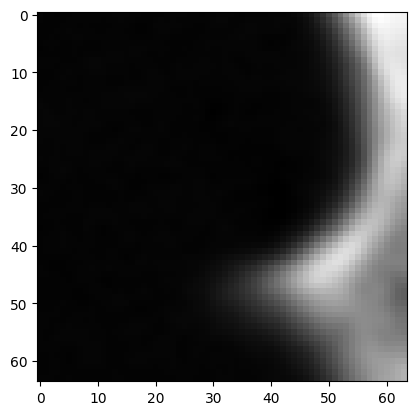

In [9]:
pyplot.imshow(y_test[1000].reshape(64,64),cmap='gray')
print(y_test.shape[0])

In [10]:
def Normalizer(u):
    u = u.reshape(u.shape[0],u.shape[1],u.shape[2],1)
    u = ((u-np.min(u))/(np.max(u)-np.min(u))).astype('float32')
    return u

In [11]:
X_test = Normalizer(X_test)
X_train = Normalizer(X_train)
y_train = Normalizer(y_train)
y_test = Normalizer(y_test)

# 3. Build and train the network

In [13]:
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Add)
from tensorflow.keras.activations import relu

class Network(tf.keras.Model):
    def __init__(self):
        super(Network,self).__init__()
        self.conv2d0 = Conv2D(filters = 96, kernel_size = (5,5),
                              strides = (1,1), name='en_conv0',
                              activation='relu', data_format='channels_last',
                              input_shape=(64,64,1))
        self.conv2d = Conv2D(filters = 96, kernel_size = (5,5),
                             strides = (1,1), name='en_conv',
                             activation='relu', data_format='channels_last')
        self.conv2dT = Conv2DTranspose(filters = 96, kernel_size = (5,5),
                                       strides = (1,1), name='de_conv',
                                       data_format = 'channels_last')
        self.conv2dT1 = Conv2DTranspose(filters = 1, kernel_size = (5,5),
                                        strides = (1,1), name='de_convf',
                                        data_format = 'channels_last')
        
    def call(self,input):
        x = self.conv2d0(input)
        x1 = self.conv2d(x)
        x = self.conv2d(x1)
        x2 = self.conv2d(x)
        x = self.conv2d(x2)

        v0 = self.conv2dT(x)
        v = Add()([x2,v0])
        v = relu(v)
        v = self.conv2dT(v)
        v1 = self.conv2dT(v)
        v = Add()([x1,v1])
        v = relu(v)
        v = self.conv2dT(v)
        v2 = self.conv2dT1(v)
        v = Add()([input,v2])
        v = relu(v)
        return v

model = Network()

In [14]:
Adam = tf.keras.optimizers.Adam()
model.compile(optimizer = Adam, loss = 'mean_squared_error')

The model is trained with decaying learning rate (0.991 * learning rate every 4 epochs). The model uses Adam optimizer for its optimization process with mean-squared error as its loss function. Accuracy metric is not used as this project is intended to correct noisy images, not classify noisy/non-noisy images.

In [15]:
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.991
    epochs_drop = 4.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
       self.val_losses = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.val_losses.append(logs.get('val_loss'))
       self.lr.append(step_decay(len(self.losses)))


loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

hist = model.fit(X_train, y_train, batch_size=16, epochs=40,
                 validation_data = (X_test, y_test),
                 callbacks = callbacks_list,
                 verbose = 2)

Epoch 1/40
4800/4800 - 233s - loss: 0.0026 - val_loss: 0.0014 - lr: 1.0000e-04 - 233s/epoch - 49ms/step
Epoch 2/40
4800/4800 - 235s - loss: 0.0013 - val_loss: 0.0012 - lr: 1.0000e-04 - 235s/epoch - 49ms/step
Epoch 3/40
4800/4800 - 237s - loss: 0.0011 - val_loss: 0.0010 - lr: 1.0000e-04 - 237s/epoch - 49ms/step
Epoch 4/40
4800/4800 - 239s - loss: 9.8334e-04 - val_loss: 9.2705e-04 - lr: 9.9100e-05 - 239s/epoch - 50ms/step
Epoch 5/40
4800/4800 - 239s - loss: 8.8394e-04 - val_loss: 8.4433e-04 - lr: 9.9100e-05 - 239s/epoch - 50ms/step
Epoch 6/40
4800/4800 - 239s - loss: 8.1776e-04 - val_loss: 7.9559e-04 - lr: 9.9100e-05 - 239s/epoch - 50ms/step
Epoch 7/40
4800/4800 - 239s - loss: 7.7460e-04 - val_loss: 7.5844e-04 - lr: 9.9100e-05 - 239s/epoch - 50ms/step
Epoch 8/40
4800/4800 - 240s - loss: 7.4579e-04 - val_loss: 7.4363e-04 - lr: 9.8208e-05 - 240s/epoch - 50ms/step
Epoch 9/40
4800/4800 - 240s - loss: 7.2464e-04 - val_loss: 7.2632e-04 - lr: 9.8208e-05 - 240s/epoch - 50ms/step
Epoch 10/40
4800

In [16]:
model.summary()

Model: "network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 en_conv0 (Conv2D)           multiple                  2496      
                                                                 
 en_conv (Conv2D)            multiple                  230496    
                                                                 
 de_conv (Conv2DTranspose)   multiple                  230496    
                                                                 
 de_convf (Conv2DTranspose)  multiple                  2401      
                                                                 
Total params: 465,889
Trainable params: 465,889
Non-trainable params: 0
_________________________________________________________________


**Shown below:** loss graph for up to 40 epochs.

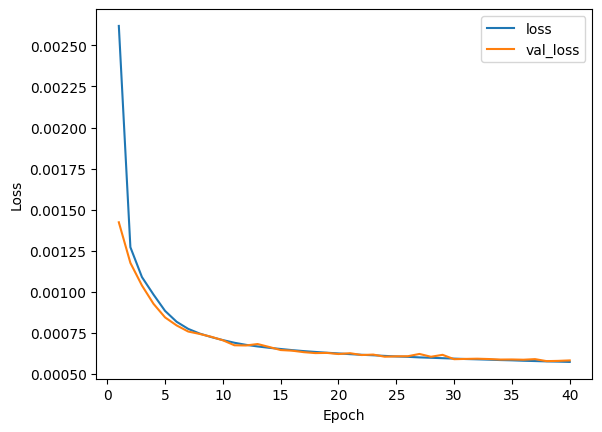

In [17]:
X = np.arange(len(loss_history.losses)) + 1
loss = pyplot.plot(X, loss_history.losses)
val_loss = pyplot.plot(X, loss_history.val_losses)
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend(['loss', 'val_loss'])

# 4. Save the model's weight

In [18]:
model.save("mymodelgaussian_CT")

INFO:tensorflow:Assets written to: mymodelgaussian_CT\assets


INFO:tensorflow:Assets written to: mymodelgaussian_CT\assets


In [ ]:
cpu_times_end = process.cpu_times()
end_time = time.time()
stop_sampling = True
sampling_thread.join()

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
pynvml.nvmlShutdown()

gpu_mem_used = mem_info.used / 1024**2  
gpu_util_percent = utilization.gpu     

execution_time = end_time - start_time
cpu_time_used = (cpu_times_end.user + cpu_times_end.system) - (cpu_times_start.user + cpu_times_start.system)
cpu_usage_percent = (cpu_time_used / execution_time) * 100 if execution_time > 0 else 0
avg_cpu_utilization = sum(cpu_utilization_samples) / len(cpu_utilization_samples) if cpu_utilization_samples else 0
ram_usage = peak / 10**6  


print(f"Execution Time: {execution_time:.2f} seconds")
print(f"CPU Usage (Script): {cpu_usage_percent:.2f}%")
print(f"CPU Utilization (System Avg): {avg_cpu_utilization:.2f}%")
print(f"Peak RAM Usage: {ram_usage:.2f} MB")
print(f"GPU Memory Used: {gpu_mem_used:.2f} MB")
print(f"GPU Utilization: {gpu_util_percent:.2f}%")

pynvml.nvmlShutdown()

Execution Time: 9786.04 seconds
CPU Usage (Script): 37.39%
CPU Utilization (System Avg): 2.68%
Peak RAM Usage: 6136.50 MB
GPU Memory Used: 5235.74 MB
GPU Utilization: 1.00%
